# Session 2
In this session, we will use the prepared dataset of EGFR activity data from Session to train ML models that predict the pIC50 value of a given molecule. 

**Content:**
1. Featuration
2. Training a random forest (RF)
    1. Data splitting
    2. Training
    3. Assessment
3. A bit about data splitting
4. Model comparision

In [11]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import statistics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


First, we reload the prepared data from Session 1 into a DataFrame:

In [12]:
egfr_activities_df = pd.read_csv("https://github.com/volkamerlab/cic_summerschool_2025/raw/refs/heads/main/data/EGFR-activities-prepared.csv", 
                                 index_col=0)
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O


## Featuration
To use molecules in machine learning models, we need to encode them numerically. We do this by generating fingerprint bit vectors for each molecule. Each molecule is then represented as a vector of fixed length ($1024$ in our example).

In [13]:
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=1024)

egfr_activities_df['morgan_fp'] = egfr_activities_df['canonical_smiles'].apply(lambda smiles : fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles)))
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles,morgan_fp
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Training a random forest (RF)
We aim to train a function that takes a bit vector as input and predicts the pIC50 value.

### Data splitting
Our goal is to be learn a (machine learning) model that generalizes well.

Therefore, we split our dataset into 2 subsets:
* A larger subset on which we will train our model called the *training set*.
* A smaller subset on which we will *test* the model. It is important that we evaluate our model on a subset of the data it has **never seen before** to ensure that we are not overfitting the data and that our model can generalize well to unseen data.

Here, we will randomly split the data. However, note that usually in a real world scenaria, one should avoid random splitting in this area to avoid data leacage, e.g., since molecules with similar scaffold have been already seen during training. (TODO rephrase)

We use the `train_test_split` function of the **sklearn** library to split 80% of the data for training and 20% for testing. **sklearn** is a machine learning library that provides several convenient functions for machine learning.

In [ ]:
df_train, df_test = train_test_split(egfr_activities_df, test_size=0.2, random_state=42)
print(f"{len(df_train)} traing samples, {len(df_test)} test samples")

We convert our fingerprints (X) and pIC50 (y) values into **NumPy** arrays. **NumPy** allows to create vectors (1D), matrices (2D), tensors (>= 3D) in the form of arrays. Further it offers a large collection of efficient numerical operations on arrays, which is crucial for machine learning.

In [24]:
X_train, y_train = np.stack(df_train['morgan_fp']), np.array(df_train['pIC50'])
X_test, y_test = np.stack(df_test['morgan_fp']), np.array(df_test['pIC50'])

In [25]:
print(f"Dimentions of training input: {X_train.shape}")
print(f"Dimentions of training output: {y_train.shape}")
print(f"Dimentions of training input: {X_test.shape}")
print(f"Dimentions of training output: {y_test.shape}")

Dimentions of training input: (5358, 1024)
Dimentions of training output: (5358,)
Dimentions of training input: (1340, 1024)
Dimentions of training output: (1340,)


### Training 
With **sklearn**, we first initialize the model, fit it to the training data using the `fit`-function, and then predict on new inputs using the `predict`-function of the model.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
y_pred_train = rf_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
r_square_train = r2_score(y_train, y_pred_train)

print(f"Train (MSE): {mse_train}")
print(f"Train (R^2): {r_square_train}")

Train (MSE): 0.09156707646344872
Train (R^2): 0.9564770804566474


### Assessment
TODO small intro whats gonna come

In [20]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print(f"Test (MSE): {mse}")
print(f"Test (R^2): {r_square}")

Test (MSE): 0.6564187034112835
Test (R^2): 0.6710319339224109


TODO

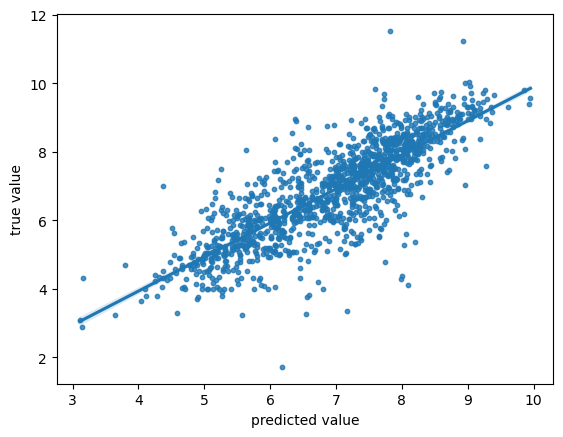

In [ ]:
sns.regplot(x = y_pred, y = y_test, scatter_kws={'s':10})
plt.ylabel('true value')
plt.xlabel('predicted value')
plt.show()

TODO comment on feature imporatnce

Top 3 bits: [428 128 621]


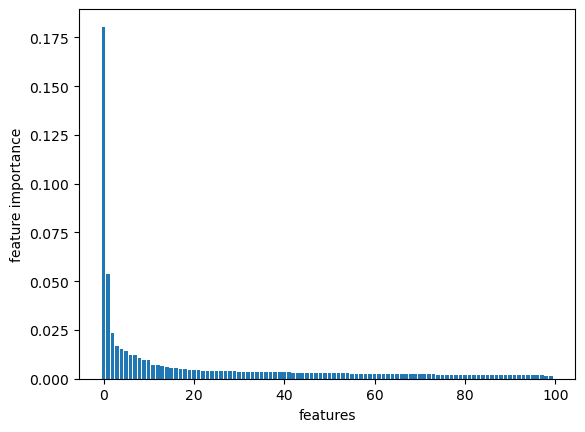

In [22]:
plt.bar(range(100), sorted(rf_model.feature_importances_, reverse=True)[:100])
plt.ylabel('feature importance')
plt.xlabel('features')
top3bits = np.argsort(rf_model.feature_importances_)[:-4:-1]
print(f"Top 3 bits: {top3bits}")

Let's look for an example for the most import bit:

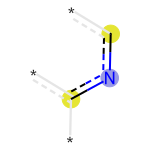

In [36]:
from IPython.display import SVG

top_bit = top3bits[0]
top_bit_active = df_train[df_train['morgan_fp'].apply(lambda fp: fp[top_bit] == 1)].reset_index(drop = True)
example_mol = Chem.MolFromSmiles(top_bit_active['canonical_smiles'][0])
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetFingerprint(example_mol, additionalOutput = ao)
bi = ao.GetBitInfoMap()
Draw.DrawMorganBit(example_mol, top_bit, bi)

SVG(Draw.DrawMorganBit(example_mol, top_bit, bi))

##  Model comparison

CV with random split?

10-fold CV

In [ ]:
kf = KFold(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_test_scores = {"MSE": [], "R2": []}

for split, (train_idx, val_idx) in enumerate(kf.split(X_cv, y_cv)):
    X_train, y_train = X_cv[train_idx], y_cv[train_idx]
    X_val, y_val = X_cv[val_idx], y_cv[val_idx]
    
    rf_model.fit(X_train, y_train)
    rf_model.predict(X)
    
    y_pred = rf_model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    r_square = r2_score(y_val, y_pred)
    
    print(f"Split {split}:\n\tMSE={mse}\n\tR^2={r_square}")
    
    rf_cv_test_scores["MSE"].append(mse)
    rf_cv_test_scores["R2"].append(mse)

Split 0:
	MSE=0.6391358367281814
	R^2=0.6717535195086208
Split 1:
	MSE=0.5759685552875256
	R^2=0.7343841153971666
Split 2:
	MSE=0.6023956520987523
	R^2=0.7055028793061981
Split 3:
	MSE=0.6116147206528161
	R^2=0.7140100738603347
Split 4:
	MSE=0.6277859853674681
	R^2=0.7000079846743568


In [ ]:
print(f"Mean validation MSE: {statistics.mean(rf_cv_test_scores['MSE']):.2f}±{statistics.stdev(rf_cv_test_scores['MSE']):.2f}")

Mean validation MSE: 0.61±0.02


## Boxplot

## Grid Search

In [ ]:
ridge = Ridge(solver = "svd")
ridge_mse_cv = cross_val_score(ridge, X_cv, y_cv, scoring='neg_mean_squared_error')
print(f"Mean validation MSE: {-ridge_mse_cv.mean():.2f}±{ridge_mse_cv.std():.2f}")

Mean validation MSE: 0.94±0.04


## Classification (?)

## Excercises

## TODO scaffold split 

### Excerise 1 (Hyperparameter tuning -> naiv)

In [ ]:
# Can the CV MSE of the RF be improved by changing the number of trees? Try different numbers here
# TODO

In [ ]:
# Do the same for Ridge

### Exercise 2 (Hyperparameter tuning -> Grid Search)

### Excerise 3 (Classification)

In [ ]:
# generate labels from pIC50, if > x => active (1), else inactive (0)
# TODO

In [ ]:
# train a RF, use f1_score as metric

In [ ]:
# in lecture learned SVM, train a SVM. Is it's performance superior to RF?

## Cluster-based Split (?) -> maybe as exercise 

### Play around with different models to beat RF

## Plot the results